In [1]:
# Initial imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import hvplot.pandas as hvplot
plt.style.use('seaborn')
# !pip install ta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import ta as ta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import intraday as it



In [2]:
df=it.grab('TSLA','15m')
df = df[['Close','Open','High','Low','Volume']]
#data cleaning
print(df.describe())
print(df.isna().sum())

[*********************100%***********************]  1 of 1 completed
             Close         Open         High          Low        Volume
count  1066.000000  1066.000000  1066.000000  1066.000000  1.066000e+03
mean    679.350852   679.467943   682.870137   675.864088  1.440834e+06
std      41.300060    41.283546    40.781579    41.882063  1.113358e+06
min     546.710022   546.390015   562.619995   539.489990  3.635790e+05
25%     660.479996   660.540466   663.639938   657.607513  7.657615e+05
50%     683.780029   684.119934   688.000000   681.100067  1.126709e+06
75%     703.883743   703.887512   706.625000   701.044998  1.732243e+06
max     776.594971   776.500000   780.779907   768.118225  1.390479e+07
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64


In [3]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [4]:
# # Predict Closing Prices using a 10 day window of previous closing prices
window_size = 20
feature_column = 0 
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [5]:
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaler = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [9]:
model = Sequential()
number_units = 20
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [10]:
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 20)            1760      
_________________________________________________________________
dropout (Dropout)            (None, 20, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [12]:
model_1=model.fit(X_train, y_train, epochs=2, shuffle=False, batch_size=1, verbose=1)

Epoch 1/2
836/836 [==============================] - 15s 13ms/step - loss: 0.0436 - mse: 0.0436
Epoch 2/2
836/836 [==============================] - 10s 13ms/step - loss: 0.0121 - mse: 0.0121


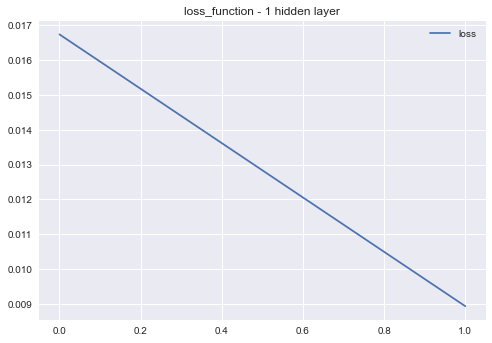

In [13]:
# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

In [14]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 6ms/step - loss: 0.0298 - mse: 0.0298


[0.029801318421959877, 0.029801318421959877]

In [15]:
predicted = model.predict(X_test)

In [16]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])

stocks.tail()


,Real,Predicted
Datetime,,
2021-04-20 14:45:00-04:00,716.859985,688.234009
2021-04-20 15:00:00-04:00,721.210022,688.232910
2021-04-20 15:15:00-04:00,720.407104,688.247498
2021-04-20 15:30:00-04:00,720.599976,688.273926
2021-04-20 15:45:00-04:00,718.789978,688.307922


<AxesSubplot:title={'center':'IF only This Actually Worked'}, xlabel='Datetime'>

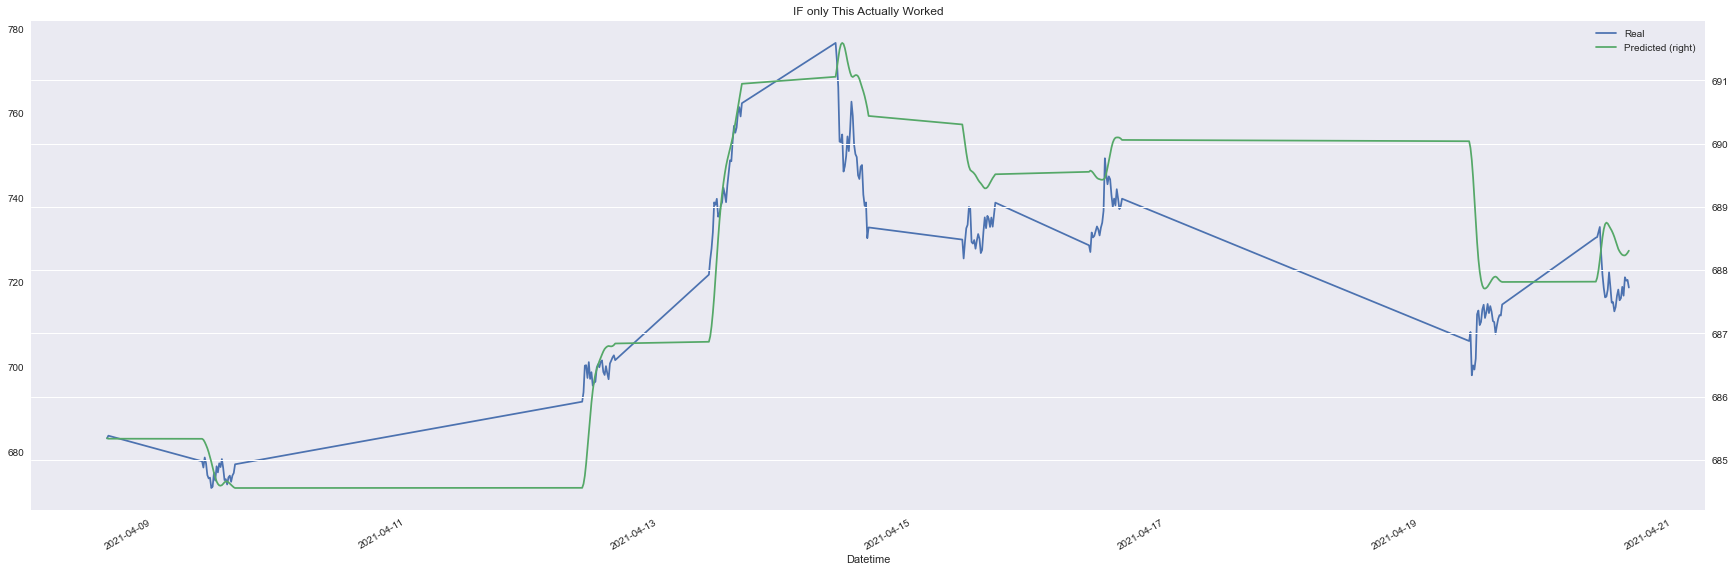

In [18]:
stocks.plot(title = "IF only This Actually Worked", figsize = (30, 10), secondary_y = 'Predicted')

In [19]:
df.reset_index(inplace = True)

In [20]:
df = df[['Datetime','Close']]
df.columns = ['Date','Close']
df.tail()

,Date,Close
1061,2021-04-20 14:45:00-04:00,716.859985
1062,2021-04-20 15:00:00-04:00,721.210022
1063,2021-04-20 15:15:00-04:00,720.407104
1064,2021-04-20 15:30:00-04:00,720.599976
1065,2021-04-20 15:45:00-04:00,718.789978


In [21]:
close_data = df.Close.values.reshape((-1))
look_back = 5
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
       
        out = model.predict(x)
        output=scaler.inverse_transform(out)
        prediction_list = np.append(prediction_list, output)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq='15min').tolist()
    return prediction_dates

num_prediction = 1
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)   


In [22]:
prediction = pd.DataFrame({"Predicted":forecast, "Date":forecast_dates})
prediction.set_index('Date')

,Predicted
Date,
2021-04-20 19:45:00,718.789978
2021-04-20 20:00:00,674.768555


In [23]:
stocks.append(prediction)

,Real,Predicted,Date
2021-04-08 15:30:00-04:00,683.130005,685.343750,NaT
2021-04-08 15:45:00-04:00,683.780029,685.335388,NaT
2021-04-09 09:30:00-04:00,677.729980,685.333679,NaT
2021-04-09 09:45:00-04:00,676.250000,685.318726,NaT
2021-04-09 10:00:00-04:00,678.630005,685.282776,NaT
...,...,...,...
2021-04-20 15:15:00-04:00,720.407104,688.247498,NaT
2021-04-20 15:30:00-04:00,720.599976,688.273926,NaT
2021-04-20 15:45:00-04:00,718.789978,688.307922,NaT
0,NaN,718.789978,2021-04-20 19:45:00


In [24]:
stocks.tail()

,Real,Predicted
Datetime,,
2021-04-20 14:45:00-04:00,716.859985,688.234009
2021-04-20 15:00:00-04:00,721.210022,688.232910
2021-04-20 15:15:00-04:00,720.407104,688.247498
2021-04-20 15:30:00-04:00,720.599976,688.273926
2021-04-20 15:45:00-04:00,718.789978,688.307922
